1. load and visualize the scenario

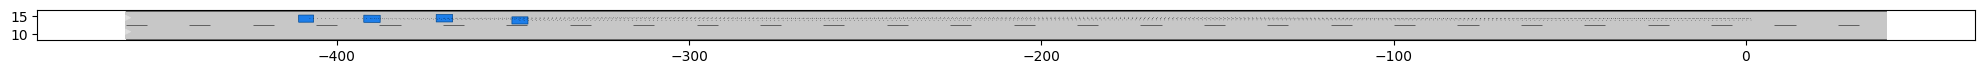

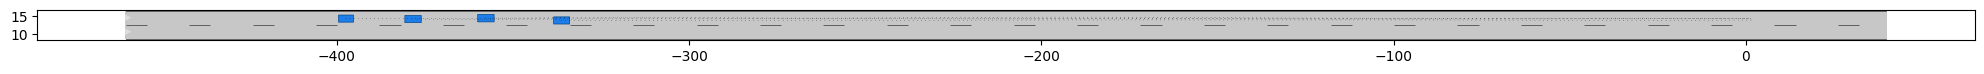

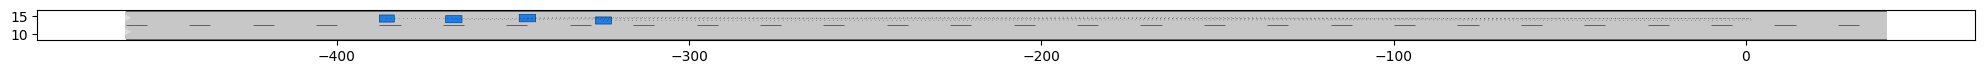

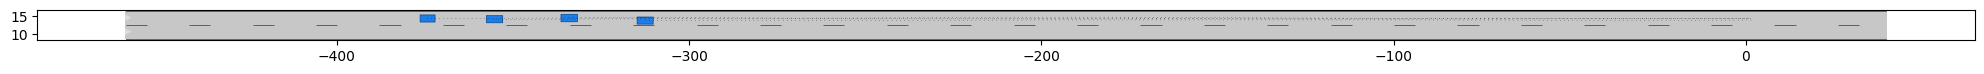

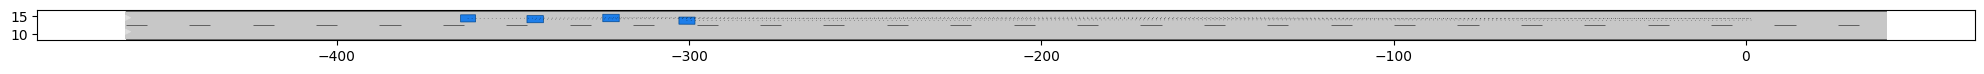

In [78]:
%matplotlib inline
import os
import scipy
# from sre_parse import State
# from turtle import position
import numpy as np
# import pkg_resources
from cvxpy import *
import matplotlib.pyplot as plt
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer


file_path = os.path.join(os.getcwd(), 'highD_01_T_1201-1800.xml')
# file_path = os.path.join(os.getcwd(), 'kernel_regression-1_0.xml') #   kernel_regression-1_0
scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

for obs in scenario.obstacles:
    if obs.obstacle_id < 10067 or obs.obstacle_id > 10070: # or obs.obstacle_id == 10066:
        # print(obs.obstacle_id)
        scenario.remove_obstacle(obs)

# scenario.remove_obstacle([scenario.obstacles[0],scenario.obstacles[1]])
translation = np.array([0.0, 0.0])
angle = np.pi
scenario.translate_rotate(translation, angle)
planning_problem_set.translate_rotate(translation, angle)

frame = 1342
for i in range(frame,frame+50,10):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    rnd.draw_params.time_begin = i
    rnd.draw_params.time_end = 1800
    scenario.draw(rnd)
    rnd.render()

2. define classes and functions

In [79]:
# from cProfile import label
from scipy.stats import norm

path = 'D:\\learn\\23SS\\guided_research\\RL\\commonroad_io\\tutorials\\data_inter\\'  #os.path.abspath(os.path.dirname(__file__))
x_data = np.load(path + 'x_cur.npy')
matlab_data = scipy.io.loadmat(path + 'solution.mat')
solution_quad = scipy.io.loadmat(path + 'solution_quad.mat')
solution_optimal = scipy.io.loadmat(path + 'solution_optimal.mat')
sol = matlab_data['x']
N_data = int((len(sol) - 1) / 2)
alphas = sol[:N_data]
# alphas_quad = solution_quad['x_quad'][:3]
alphas_opti = solution_optimal['x_optimal'].reshape((3, 1))


class Parameters:
    beta = 0.2
    dt = 0.04
    h = 0.913008
    A = np.array([[1, dt], [0, 1]])
    B = np.array([-dt * (h + dt), -dt])
    D = np.array([dt * dt, dt])
    random_size = 10
    sigma = 0.6212


# # define optimal policy function
# def policy_kernel(x, x_data, alphas, p: Parameters):
#     sum_ = 0
#     for i in range(N_data):
#         sum_ += 2 * alphas[i] * x_data[i] * (1 + x_data[i] @ (p.A @ x))
#     return -p.beta * sum_ @ p.B


def policy_kernel(u, u_p, x, data, alp, p: Parameters):
    sum_ = 0
    noises = norm.rvs(loc=0, scale=p.sigma, size=(p.random_size))
    for noise in noises:
        for i in range(N_data):
            sum_ += 2 * alp[i] * data[i] * (
                1 + data[i] @ (p.A @ x + p.B * (u + noise) + p.D * u_p))
    # for i in range(N_data):
    #     sum_ += 2 * alp[i] * data[i] * (
    #         1 + data[i] @ (p.A @ x + p.B * u + p.D * u_p))  # + p.D * u_p))
    return u + p.beta * sum_ @ p.B / p.random_size


# def policy_quadratic(x, alphas_quad, p: Parameters):
#     a = alphas_quad
#     x_next = p.A @ x
#     return -p.beta * 2 * p.B @ np.array([
#         a[0] * x_next[0] + a[1] * x_next[1],
#         a[1] * x_next[0] + a[2] * x_next[1]
#     ])


def policy_quadratic(u, u_p, x, alphas_quad, p: Parameters):
    a = alphas_quad
    x_next = p.A @ x + p.B * u + p.D * u_p
    return u + p.beta * 2 * p.B @ np.array([
        a[0] * x_next[0] + a[1] * x_next[1],
        a[1] * x_next[0] + a[2] * x_next[1]
    ])


# class TIConstraints:
#     a_min = -8
#     a_max = 15
#     s_min = 0
#     s_max = 150
#     v_min = 0
#     v_max = 35


def plot_state(x_p, pos, vel, u, pos_q, vel_q, u_q, data_pre, data_fol,
               p: Parameters):
    plt.figure(figsize=(6, 12))
    N = pos.shape[0] - 1

    # Plot (x_t)_1.
    plt.subplot(5, 1, 1)
    # x1 = (x.value)[0, :].flatten() - h * (x.value)[1, :].flatten()
    plt.plot(np.array(range(N + 1)), pos, 'g', label='kernel')
    plt.plot(np.array(range(N + 1)), pos_q, 'r', label='quadratic')
    plt.plot(np.array(range(N + 1)), data_fol[:, 0], 'b', label='data')
    plt.ylabel(r"$s$", fontsize=16)
    plt.legend()
    # plt.yticks(np.linspace(c.s_min, s_max, 3))
    # plt.ylim([c.s_min, s_max])
    plt.xticks([])
    plt.grid()

    # Plot (x_t)_2.
    plt.subplot(5, 1, 2)
    plt.plot(np.array(range(N + 1)), vel, 'g', label='kernel')
    plt.plot(np.array(range(N + 1)), x_p[:, 1], 'y', label='preceding')
    plt.plot(np.array(range(N + 1)), vel_q, 'r', label='quadratic')
    plt.plot(np.array(range(N + 1)), data_fol[:, 1], 'b', label='data')
    plt.ylabel(r"$v$", fontsize=16)
    plt.legend()
    plt.xticks([])
    plt.grid()

    plt.subplot(5, 1, 3)
    plt.plot(np.array(range(N + 1)), u, 'g', label='kernel')
    plt.plot(np.array(range(N + 1)), x_p[:, 2], 'y', label='preceding')
    plt.plot(np.array(range(N + 1)), u_q, 'r', label='quadratic')
    plt.plot(np.array(range(N + 1)), data_fol[:, 2], 'b', label='data')
    plt.ylabel(r"$a$", fontsize=16)
    plt.legend()
    plt.xticks([])
    plt.grid()

    # Plot (x_t)_3.
    plt.subplot(5, 1, 4)
    x1 = x_p[:, 0] - pos - p.h * vel
    x1_q = x_p[:, 0] - pos_q - p.h * vel_q
    x1_data = data_pre[:, 0] - data_fol[:, 0] - p.h * data_fol[:, 1]
    plt.plot(np.array(range(N + 1)), x1, 'g', label='kernel')
    plt.plot(np.array(range(N + 1)), x1_q, 'r', label='quadratic')
    plt.plot(np.array(range(N + 1)), x1_data, 'b', label='data')
    plt.legend()
    plt.ylabel(r"$x1$", fontsize=16)
    plt.xticks([])
    plt.grid()

    # Plot (x_t)_4.
    plt.subplot(5, 1, 5)
    x2 = x_p[:, 1] - vel
    x2_q = x_p[:, 1] - vel_q
    x2_data = data_pre[:, 1] - data_fol[:, 1]
    plt.plot(np.array(range(N + 1)), x2, 'g', label='kernel')
    plt.plot(np.array(range(N + 1)), x2_q, 'r', label='quadratic')
    plt.plot(np.array(range(N + 1)), x2_data, 'b', label='data')
    plt.legend()
    plt.ylabel(r"$x2$", fontsize=16)
    plt.xticks([])
    plt.xticks(np.arange(0, N + 1, 20))
    plt.xlabel(r"$k$", fontsize=16)
    plt.tight_layout()
    plt.grid()
    plt.show()

3. set parameters

In [80]:
# problem data
N_vehicles = len(scenario.obstacles)
# N = 100  # number of time steps
n = 2  # length of state vector
# m = 1  # length of input vector
dt = scenario.dt  # time step

# set up constraints
# c = TIConstraints()
# c.a_min = -6  # Minimum feasible acceleration of vehicle
# c.a_max = 6  # Maximum feasible acceleration of vehicle
# c.s_min = 0  # Minimum allowed position
# c.s_max = 130  # Maximum allowed position
# c.v_min = 0  # Minimum allowed velocity
# c.v_max = 35  # Maximum allowed velocity (speed limit)

# set up system parameters
p = Parameters()

# weights for cost function
w_s = 0.0008
w_v = 0.9882  #0.9882
Q = np.eye(n) * np.transpose(np.array([w_s, w_v]))
w_u = 2.5
R = w_u
p.beta = 0.5  # / R

# terms of system dynamic
p.h = 0.913008
p.A = np.array([[1, dt], [0, 1]])
p.B = np.array([-dt * (p.h + dt), -dt])

4. record states to be compared

In [81]:
initial_frame = scenario.obstacles[-1].prediction.initial_time_step + 10
end_frame = scenario.obstacles[0].prediction.final_time_step
N_frames = end_frame - initial_frame
N = int(N_frames)
print(N_frames)

initial_states = np.zeros((N_vehicles, 3))
for i in range(len(scenario.obstacles)):
    obs = scenario.obstacles[i]
    initial_states[i, 0] = obs.state_at_time(initial_frame).position[0]
    initial_states[i, 1] = obs.state_at_time(initial_frame).position[1]
    initial_states[i, 2] = obs.state_at_time(initial_frame).velocity

state_data = []
for obs in scenario.obstacles:
    states_obs = np.zeros((N + 1, 3))
    for j in range(N + 1):
        states_obs[j, 0] = obs.state_at_time(initial_frame + j).position[0]
        states_obs[j, 1] = obs.state_at_time(initial_frame + j).velocity
        states_obs[j, 2] = obs.state_at_time(initial_frame + j).acceleration
    state_data.append(states_obs)

# print(len(state_data))

282


5. remove all following vehicles

In [82]:
for obs in scenario.obstacles:
    if obs.obstacle_id != 10067:
        # print(obs.obstacle_id)
        scenario.remove_obstacle(obs)

6. magic happens

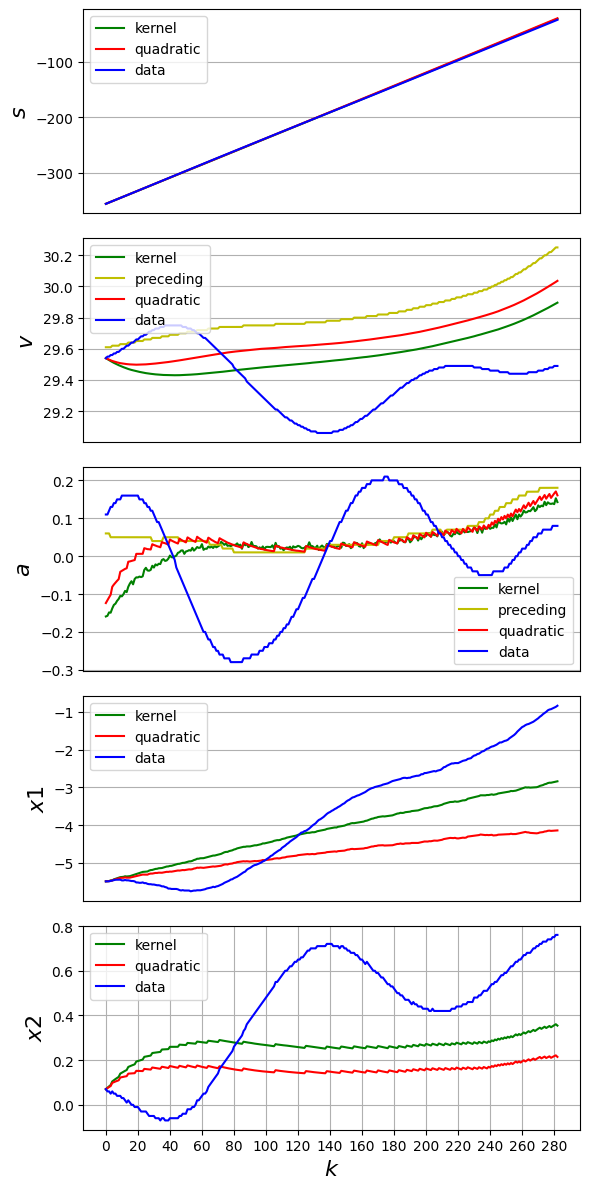

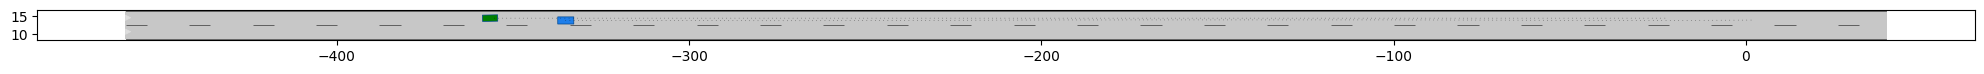

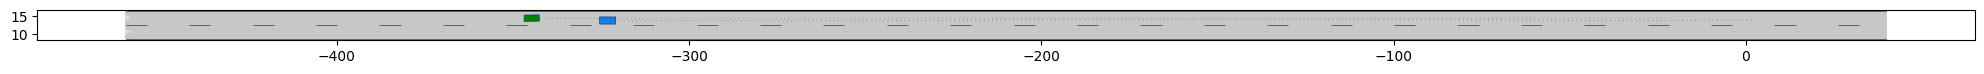

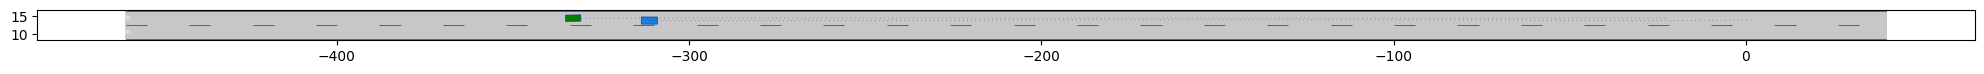

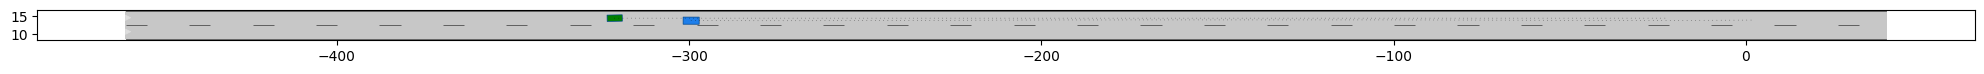

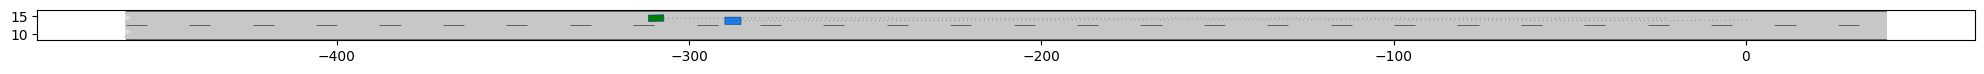

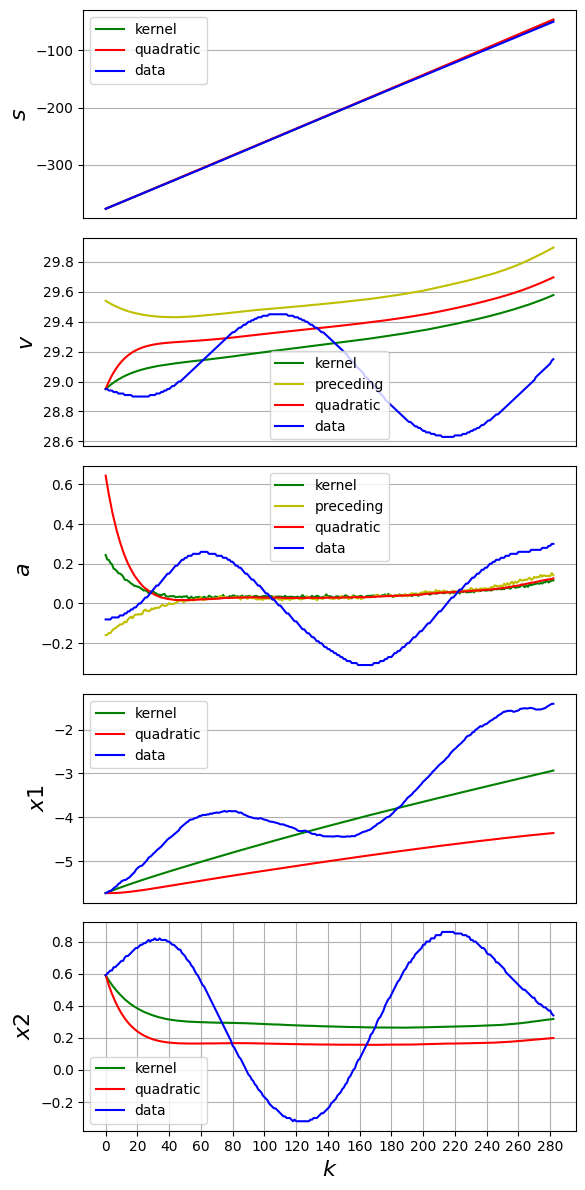

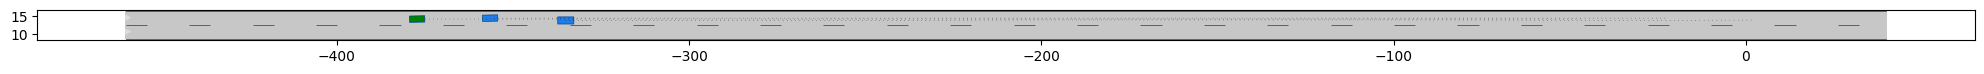

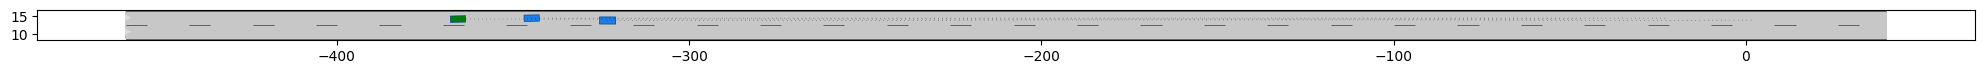

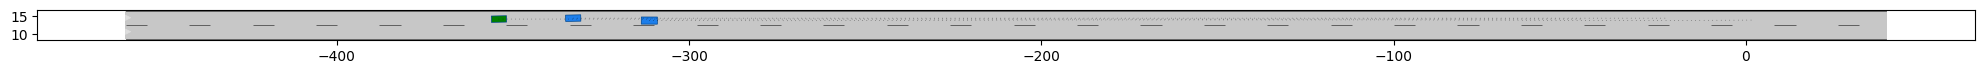

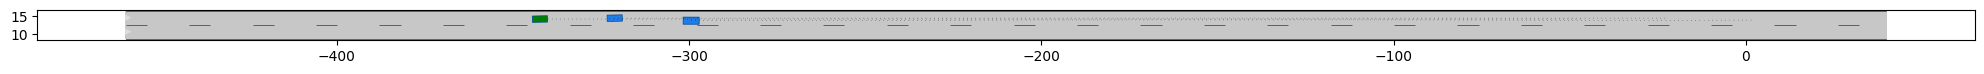

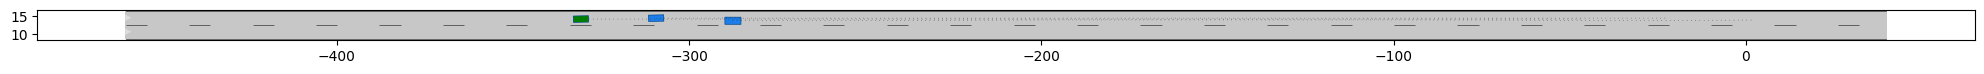

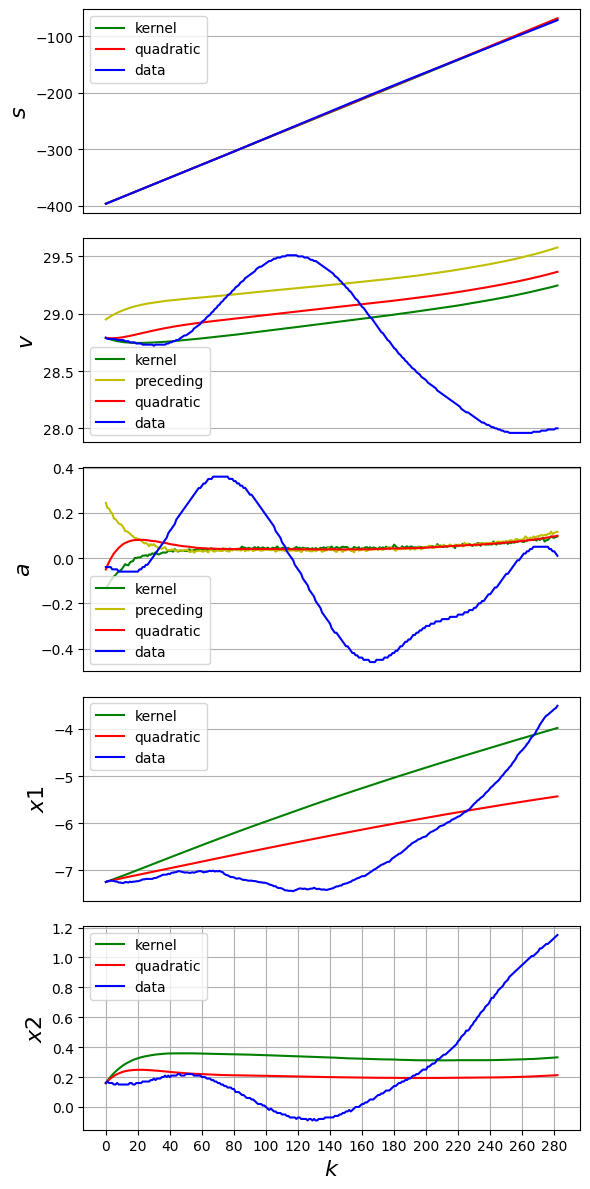

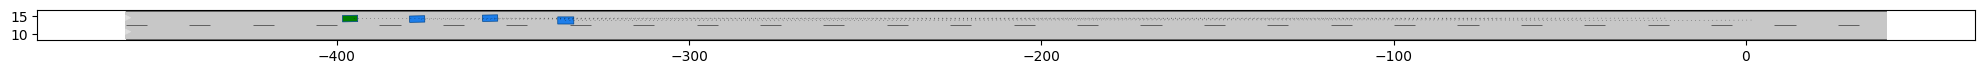

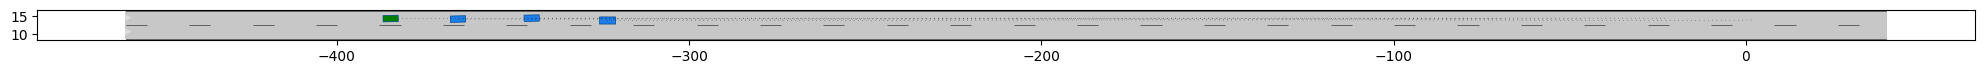

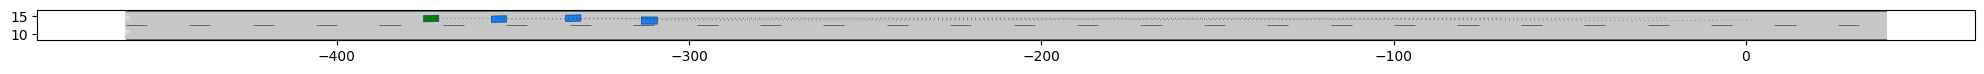

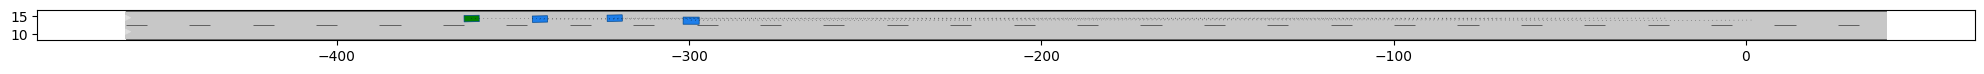

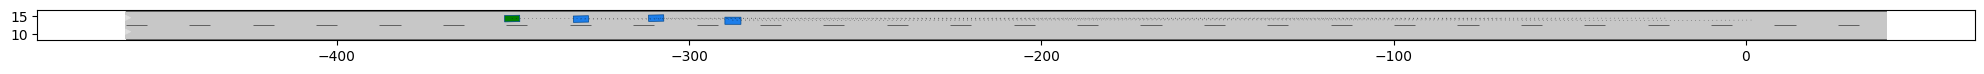

In [83]:
# import necessary classes from different modules
from scipy.optimize import brentq
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.obstacle import ObstacleType, DynamicObstacle
from commonroad.scenario.state import InitialState, CustomState
from commonroad.scenario.trajectory import Trajectory
from commonroad.prediction.prediction import TrajectoryPrediction
from commonroad.visualization.draw_params import DynamicObstacleParams

for i in range(N_vehicles - 1):  #N_vehicles - 1):
    vehicle_pre = scenario.obstacles[i]
    x_pre = np.zeros((N + 1, 3))
    for j in range(N + 1):
        x_pre[j, 0] = vehicle_pre.state_at_time(initial_frame + j).position[0]
        x_pre[j, 1] = vehicle_pre.state_at_time(initial_frame + j).velocity
        x_pre[j, 2] = vehicle_pre.state_at_time(initial_frame + j).acceleration
    # print(x_pre[0])

    initial_position = initial_states[i + 1, 0]
    initial_velocity = initial_states[i + 1, 2]

    x_initial = x_pre[0, :2] - np.array(
        [initial_position + p.h * initial_velocity, initial_velocity])

    state_in_root_policy = x_initial
    u_pre = x_pre[0, 2]

    def root_policy_ker(u):
        return policy_kernel(u, u_pre, state_in_root_policy, x_data, alphas, p)

    def root_policy_quad(u):
        return policy_quadratic(u, u_pre, state_in_root_policy, alphas_opti, p)

    x = np.zeros((N + 1, 2))
    x[0, :] = x_initial

    u = np.zeros(N + 1)
    u[0] = brentq(root_policy_ker, -5, 5)

    x_quad = np.zeros((N + 1, 2))
    x_quad[0, :] = x_initial

    u_quad = np.zeros(N + 1)
    # u_quad[0] = policy_quadratic(x_initial, alphas_quad, p)
    u_quad[0] = brentq(root_policy_quad, -5, 5)

    # u[0] = vf_weight * (policy_kernel(x_initial, x_data, alphas, p) if kernel
    #                     else policy_quadratic(x_initial, alphas_quad, p))

    # for j in range(N):
    #     x[j + 1, :] = p.A @ x[j, :] + p.B * u[j] + p.D * x_pre[j, 2]
    #     x_quad[j + 1, :] = p.A @ x_quad[j, :] + p.B * u_quad[j]
    #     state_in_root_policy = x[j + 1, :]
    #     u_pre = x_pre[j, 2]
    #     u[j + 1] = brentq(policy_kernel, -5, 5)
    #     u_quad[j + 1] = policy_quadratic(x_quad[j + 1, :], alphas_quad, p)

    # vel = x_pre[:, 1] - x[:, 1]
    # pos = x_pre[:, 0] - x[:, 0] - p.h * vel
    # vel_quad = x_pre[:, 1] - x_quad[:, 1]
    # pos_quad = x_pre[:, 0] - x_quad[:, 0] - p.h * vel_quad

    pos, vel = np.zeros(N + 1), np.zeros(N + 1)
    pos[0], vel[0] = initial_position, initial_velocity
    pos_quad, vel_quad = np.zeros(N + 1), np.zeros(N + 1)
    pos_quad[0], vel_quad[0] = initial_position, initial_velocity
    for j in range(N):
        vel[j + 1] = vel[j] + dt * u[j]
        pos[j + 1] = pos[j] + dt * vel[j + 1]
        x[j + 1, :] = x_pre[j + 1, :2] - np.array(
            [pos[j + 1] + p.h * vel[j + 1], vel[j + 1]])
        state_in_root_policy = x[j + 1, :]
        u_pre = x_pre[j, 2]
        u[j + 1] = brentq(root_policy_ker, -5, 5)

        vel_quad[j + 1] = vel_quad[j] + dt * u_quad[j]
        pos_quad[j + 1] = pos_quad[j] + dt * vel_quad[j + 1]
        x_quad[j + 1, :] = x_pre[j + 1, :2] - np.array(
            [pos_quad[j + 1] + p.h * vel_quad[j + 1], vel_quad[j + 1]])
        # u_quad[j + 1] = policy_quadratic(x_quad[j + 1, :], alphas_quad, p)
        state_in_root_policy = x_quad[j + 1, :]
        u_pre = x_pre[j, 2]
        u_quad[j + 1] = brentq(root_policy_quad, -5, 5)

    # print(u)
    # print(u_quad)
    # print(res)

    plot_state(x_pre, pos, vel, u, pos_quad, vel_quad, u_quad, state_data[i],
               state_data[i + 1], p)
    ###################

    # initial state has a time step of 0
    dynamic_obstacle_initial_state = CustomState(
        position=np.array([pos[0], initial_states[i + 1, 1]]),
        velocity=vel[0],
        acceleration=u[0],
        orientation=0.02,
        time_step=initial_frame).convert_state_to_state(InitialState())

    # generate the states for the obstacle for time steps 1 to 40 by assuming constant velocity
    state_list = [
        CustomState(position=np.array([pos[j], initial_states[i + 1, 1]]),
                    velocity=vel[j],
                    acceleration=u[j],
                    orientation=0.02,
                    time_step=initial_frame + j) for j in range(1, N + 1)
    ]
    # print(state_list[:10])

    # create the trajectory of the obstacle, starting at time step 1
    dynamic_obstacle_trajectory = Trajectory(initial_frame + 1, state_list)

    # create the prediction using the trajectory and the shape of the obstacle
    dynamic_obstacle_shape = Rectangle(width=1.8, length=4.3)
    dynamic_obstacle_prediction = TrajectoryPrediction(
        dynamic_obstacle_trajectory, dynamic_obstacle_shape)

    # generate the dynamic obstacle according to the specification
    dynamic_obstacle_id = scenario.generate_object_id()
    dynamic_obstacle_type = ObstacleType.CAR
    dynamic_obstacle = DynamicObstacle(dynamic_obstacle_id,
                                       dynamic_obstacle_type,
                                       dynamic_obstacle_shape,
                                       dynamic_obstacle_initial_state,
                                       dynamic_obstacle_prediction)
    ego_vehicle = dynamic_obstacle

    # plot the scenario and the ego vehicle for each time step
    ego_params = DynamicObstacleParams()
    ego_params.vehicle_shape.occupancy.shape.facecolor = "g"
    for j in range(initial_frame, initial_frame + 50, 10):
        plt.figure(figsize=(25, 10))
        rnd = MPRenderer()
        rnd.draw_params.time_begin = j
        rnd.draw_params.time_end = 1800
        scenario.draw(rnd)
        ego_params.time_begin = j
        ego_params.time_end = 1800
        ego_vehicle.draw(rnd, draw_params=ego_params)
        rnd.render()

    # add dynamic obstacle to the scenario
    scenario.add_objects(ego_vehicle)
